In [1]:
from google.colab import files
uploaded = files.upload()



Saving data.zip to data.zip


In [ ]:
import zipfile
import os

 
zip_path = 'data.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('unzipped_folder')  # to extract  the folder and name it unzipped_folder

 
os.listdir('unzipped_folder')



['data']

In [5]:
!unzip unzipped_folder/data/MuseData.zip


Archive:  unzipped_folder/data/MuseData.zip
  inflating: MU.txt                  


In [17]:
!unzip unzipped_folder/data/MWData.zip


Archive:  unzipped_folder/data/MWData.zip
  inflating: MWData/MW.txt           


In [ ]:
 # To confirm the existance of MU.txt in the root directory
import os

for root, dirs, files in os.walk('/content'):
    for file in files:
        if file == 'MU.txt':
            print(os.path.join(root, file))


/content/MU.txt


In [5]:
import pandas as pd
MU = pd.read_csv("/content/MU.txt", delimiter="\t")
print(MU.head())






   978111  132669  MU   TP9  6  459  \
0  978112  132669  MU   FP1  6  459   
1  978113  132669  MU   FP2  6  459   
2  978114  132669  MU  TP10  6  459   
3  978115  132670  MU   TP9  7  493   
4  978116  132670  MU   FP1  7  493   

  475,474,477,486,486,476,479,483,489,483,482,485,486,483,474,475,484,481,482,478,476,479,487,481,480,479,487,486,471,487,491,488,491,470,460,485,484,482,485,480,487,488,479,471,479,485,484,484,478,478,479,511,524,529,530,529,525,524,533,520,516,520,525,526,521,519,526,527,529,520,520,514,522,523,514,515,517,523,517,515,528,522,530,520,519,504,532,529,528,532,523,531,524,514,522,524,524,519,516,512,519,519,526,517,519,512,523,527,518,530,529,527,524,519,522,520,516,527,525,522,528,524,518,524,530,522,518,514,518,533,521,526,527,524,524,527,512,519,520,519,515,522,535,528,528,526,526,539,528,519,528,527,523,529,519,511,524,522,525,520,515,519,522,519,517,521,528,523,527,530,515,532,526,528,518,523,535,528,524,532,529,522,519,524,532,529,523,503,513,519,516

In [6]:
MW = pd.read_csv("/content/MWData/MW.txt", delimiter="\t")

print(MW.head())

   0  0.1  MW  FP1  0.2  1017  \
0  1    1  MW  FP1    1   889   
1  2    2  MW  FP1    4  1017   
2  3    3  MW  FP1    1  1017   
3  4    4  MW  FP1    8   952   
4  5    5  MW  FP1    4  1015   

  38,48,51,44,48,56,56,41,20,-3,-9,-1,6,5,6,17,24,38,56,57,52,52,48,37,39,51,51,40,37,34,27,25,23,21,25,37,43,45,53,57,60,71,73,67,58,51,40,40,53,72,88,89,88,92,88,81,92,117,124,119,123,140,144,140,147,150,154,152,140,131,122,122,133,148,162,169,171,162,146,135,139,154,162,154,145,150,164,166,156,140,134,150,168,156,123,107,112,107,103,103,109,128,136,130,115,96,86,100,124,131,100,64,56,76,105,128,118,93,66,48,44,48,53,53,48,33,33,41,56,70,72,69,69,86,96,80,67,67,69,60,53,52,53,54,54,54,61,70,68,68,71,72,69,70,77,76,66,60,71,68,48,19,19,50,67,58,49,39,34,42,67,80,70,59,55,38,24,37,59,70,54,26,16,11,19,33,41,41,34,27,25,34,32,5,-12,-1,29,41,27,9,4,7,8,-3,-11,-9,-2,-6,-22,-35,-34,-17,-7,-12,-12,2,10,4,5,10,18,16,12,24,26,21,20,20,25,28,25,21,10,-11,-37,-42,-34,-13,5,16,10,-2,-21,-34,-25,-4,4,

In [ ]:
eeg_data_mu = MU.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce').values
trigger_mu = MU.iloc[:, -1].values     

eeg_data_MW = MW.iloc[:, 1:-1].apply(pd.to_numeric, errors='coerce').values
trigger_MW = MW.iloc[:, -1].values    



In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

fs = 250   
filtered = bandpass_filter(eeg_data_mu, 0.1, 30.0, fs)
filtered_MW = bandpass_filter(eeg_data_MW, 0.1, 30.0, fs)


In [ ]:
# Step 5: Detect stimulus events  
event_indices_mu = [i for i, val in enumerate(trigger_mu) if val != 0]
print("Found", len(event_indices_mu), "stimulus eventsN for muse")


 
event_indices_MW = [i for i, val in enumerate(trigger_MW) if val != 0]
print("Found", len(event_indices_MW), "stimulus events FOR mw.")



Found 163931 stimulus eventsN for muse
Found 67634 stimulus events FOR mw.


In [ ]:
import numpy as np

pre = int(0.2 * fs)   # samples before event
post = int(0.8 * fs)  # samples after event

# For the first signal  
epochs_mu = []
for idx in event_indices_mu:
    if idx - pre >= 0 and idx + post < len(filtered):
        epoch_mu = filtered[idx - pre : idx + post]
        epochs_mu.append(epoch_mu)

epochs_mu = np.array(epochs_mu)   
print("Epochs shape (filtered):", epochs_mu.shape)

# For the second signal  
epochs_MW = []
for idx in event_indices_MW:
    if idx - pre >= 0 and idx + post < len(filtered_MW):
        epoch_MW = filtered_MW[idx - pre : idx + post]
        epochs_MW.append(epoch_MW)   

epochs_MW = np.array(epochs_MW)  
print("Epochs shape (filtered_MW):", epochs_MW.shape)  





Epochs shape (filtered): (163681, 250, 5)
Epochs shape (filtered_MW): (67384, 250, 5)


In [ ]:
from scipy.interpolate import interp1d
import numpy as np

 

def resample_epoch(epoch, target_len):
    x_old = np.linspace(0, 1, epoch.shape[0])
    x_new = np.linspace(0, 1, target_len)
    return np.array([interp1d(x_old, ch)(x_new) for ch in epoch.T]).T

def interpolate_nans(epoch):
    for ch in range(epoch.shape[1]):
        x = np.arange(epoch.shape[0])
        y = epoch[:, ch]
        mask = np.isnan(y)
        if np.all(mask):
            continue  # skipping the chanells that include nans 
        y[mask] = np.interp(x[mask], x[~mask], y[~mask])
        epoch[:, ch] = y
    return epoch

def process_epochs(epochs):
    target_len = int(np.median([ep.shape[0] for ep in epochs]))
    resampled = np.array([resample_epoch(e, target_len) for e in epochs])
    cleaned = np.array([interpolate_nans(e) for e in resampled])
    return cleaned

#  Apply to Both Epoch Sets  

cleaned_epochs = process_epochs(epochs_mu)
cleaned_epochs_MW = process_epochs(epochs_MW)

# printing the final epochs 
print("Cleaned  MU Epochs shape:", cleaned_epochs.shape)
print("Cleaned MW Epochs shape:", cleaned_epochs_MW.shape)





Cleaned Epochs shape: (163681, 250, 5)
Cleaned MW Epochs shape: (67384, 250, 5)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# This function will normalise the epochs 
def normalize_epoch(epoch):
    scaler = MinMaxScaler()
    return scaler.fit_transform(epoch)

# Then applying the epochs to both datasets
normalized_epochs = np.array([normalize_epoch(e) for e in cleaned_epochs])
normalized_epochs_MW = np.array([normalize_epoch(e) for e in cleaned_epochs_MW])

 
print("Normalized Epochs shape:", normalized_epochs.shape)
print("Normalized MW Epochs shape:", normalized_epochs_MW.shape)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray

Normalized Epochs shape: (163681, 250, 5)
Normalized MW Epochs shape: (67384, 250, 5)


NameError: name 'normalized_epochs' is not defined

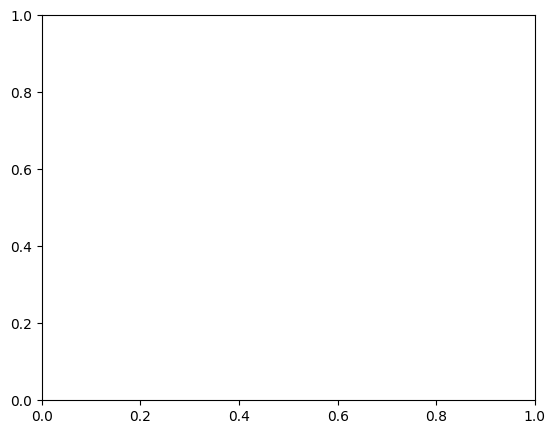

In [2]:
import matplotlib.pyplot as plt

 
plt.figure(figsize=(14, 5))

 
plt.subplot(1, 2, 1)
plt.plot(normalized_epochs[0] , color = 'green')
plt.title("Normalized EEG Epoch (MU - First Trial)")
plt.xlabel("Time points")
plt.ylabel("Normalized amplitude")
plt.grid(True)

 
plt.subplot(1, 2, 2)
plt.plot(normalized_epochs_MW[0], color = 'blue')
plt.title("Normalized EEG Epoch (MW - First Trial)")
plt.xlabel("Time points")
plt.ylabel("Normalized amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()
